# Neural network-based model for the identification of Bladder Cancers subtypes

## One graph only

### Pretreatment of the data:
- necessary libraries imports
- dataframe definition
- dataframe sorting and cleaning

In [1]:
# Libraries imports
import os
import torch
os.environ['TORCH'] = torch.__version__
import torch.nn.functional as F
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Dataframe definition
Dataframe_Labels = pd.read_csv("../BLCA_DATA/Workspace/labels_str.csv")          # Contains the labels of each patient (=cancer)
Dataframe_link = pd.read_csv("../BLCA_DATA/Workspace/patient_norm.csv")          # Contains the clinic datas of each patient (will be used for link initialization)
Dataframe_node = pd.read_csv("../BLCA_DATA/Workspace/node_embedding.csv")        # Contains the omic datas of each patient (will be used for node initialization)

# Adding a column to associate each class to a integer
Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])

# Filtering the dataframe to get rid of the two last classes (not enough datas)
Dataframe_Labels = Dataframe_Labels[~Dataframe_Labels['class_int'].isin([4, 5])]

patients_to_keep = Dataframe_Labels['Patient'].unique()
Dataframe_link = Dataframe_link[Dataframe_link['Patient'].isin(patients_to_keep)]
Dataframe_node = Dataframe_node[Dataframe_node['Patient'].isin(patients_to_keep)]

# Reset the labels to get clean Dataframes
Dataframe_Labels = Dataframe_Labels.reset_index(drop=True)
Dataframe_link = Dataframe_link.reset_index(drop=True)
Dataframe_node = Dataframe_node.reset_index(drop=True)
len(Dataframe_Labels)


/home/remax/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_11525/837405812.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


FileNotFoundError: [Errno 2] No such file or directory: '../../BLCA_DATA/Workspace/labels_str.csv'

### Graph initialization (weight, nodes and links)

Each weight is defined following this formula :
$$\mu = \text{mean of the number of patient victim of a type of cancer}$$
$$n_i = \text{number of victim of each cancer}$$
$$w_i = \text{weight of the ith class}$$

$$w_i = \frac{\frac{\mu}{n_i}}{\sum \left( \frac{\mu}{n_j} \right)}$$

In [ ]:
# class dictionnary 
classes_dict = {0: 'LumP', 
                1: 'Ba/Sq', 
                2: 'LumU', 
                3: 'Stroma-rich'
}

# This function aims at giving weight to each node depending on which cancer the patient has
# It gives the classes contained in the tensor and the weights of each class in the graph
def count_classes_weights(tensor):
    array = tensor.numpy()
    classes_tab = { 0: 0, 
                    1: 0,
                    2: 0, 
                    3: 0
    }
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    used_classes = []
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *50
            used_classes.append(classes_dict[i])

    return used_classes, weight_dict

Nodes and links initialization :

In [ ]:
# Definition of the features that will be used to define each node 
node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

# This function aims at creating a Data object that will store the caracteristics of a graph
# It needs:
# - indices (which are the patient wanted in the graph)
# - similarity_threshold (which level of similarity is considered big enough to build a link between two nodes)
# - num_classes (how many classes do we want to identify, default = 4)
def get_data(indices, similarity_threshold, num_classes=4):
    x_data = node_features[indices]

    # Setting a similarity between patients - we use cosine_similarity
    patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])

    # Calculate the edges indexes and attention coefficients
    edge_index = []
    edge_attr = []
    # These will help to reorder the nodes 
    re_indexed_i = 0
    re_indexed_j = 0
    for i in indices:
        for j in indices:
            if i >= j :
                break
            if patient_similarity[i, j] > similarity_threshold:
                edge_index.append([re_indexed_i, re_indexed_j])
                edge_attr.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
            re_indexed_j +=1
        re_indexed_i +=1
        re_indexed_j = 0

    # Setting the labels of each nodes
    node_labels = Dataframe_Labels["class_int"].values
    labels = torch.tensor(node_labels[indices], dtype=torch.long)

    # Setting the weight
    node_labels = torch.tensor(node_labels, dtype=torch.long)
    used_classes, weight_dict = count_classes_weights(node_labels)
    Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]
    node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)

    # Setting the features, connexions (edge_index and edge _attr) and weight of each nodes
    edge_features = torch.tensor(x_data, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_weights = node_weights[indices]

    # Data object definition
    data = Data(
        x=edge_features,                       # node informations 
        edge_index=edge_index,                 # node connexions (which nodes are connected)
        edge_attr=edge_attr,                   # node connexions (importance of each connexion)
        y=labels,                              # node labels
        weights=node_weights,                  # node weight
        num_classes=num_classes,               # number of classes in the graph
        num_nodes = len(edge_features),        # number of nodes
        num_features = edge_features.shape[1], # number of features
        indices = indices                      # original indices of each nodes (in the dataframe)
    )

    return data


### Graph neural network definition: GATv2

source code available at: https://github.com/tech-srl/how_attentive_are_gats

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch_geometric.nn import GATv2Conv
import seaborn as sn

# GATv2 initialization
class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads, data):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x
    
# Entropy loss function
def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

# Train function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, model

# Test function
def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

### First step: Construction of one graph

The idea in this first step is to build a One-graph only model that will help to undersand how the induction method works.
We build a graph composed of train nodes and validation nodes. The model trained on this graph is then tested on another graph (the test graph), composed of the test nodes.

In [ ]:
# Definition of the cross validation function
def cross_validation_one_graph(data, k_folds, hidden_channels, heads, num_epochs=1000):

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)
    all_val_acc = []

    best_acc = 0 

    for fold, (train_index, val_index) in enumerate(skf.split(data.x, data.y)):

        # Define train and validation masks
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[train_index] = True
        
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask[val_index] = True

        # Initialize model, optimizer, and loss function
        model = GATv2(hidden_channels=hidden_channels, heads=heads, data=data)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        lost_function_compil = []
        all_val_acc_plot = []

        # Training loop
        for epoch in range(1, num_epochs):
            loss, model = train(model, data, optimizer)
            train_acc, _ = test (model, data, data.train_mask)
            val_acc, _ = test(model, data, data.val_mask)
            lost_function_compil.append(loss.detach().tolist())
            all_val_acc_plot.append(val_acc)

            print(f'Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')

        # Evaluate on validation set
        val_acc, y_pred = test(model, data, data.val_mask)
        y_true = data.y[data.val_mask]

        # getting the most efficient model
        if val_acc > best_acc:
            best_model = model

        # Store results
        all_val_acc.append(val_acc)
        conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

        # Plot confusion matrix
        labels=['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich']
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=labels, columns=labels)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        # Plot the loss function and the accuracy improvement
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return best_model, mean_val_acc

/tmp/ipykernel_88353/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_88353/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Fold: 1, Epoch: 001, Loss: 17.8883, Train_acc 0.5477, Val_acc 0.5246
Fold: 1, Epoch: 002, Loss: 20.6832, Train_acc 0.5436, Val_acc 0.5246
Fold: 1, Epoch: 003, Loss: 15.9111, Train_acc 0.7801, Val_acc 0.8361
Fold: 1, Epoch: 004, Loss: 13.5055, Train_acc 0.5560, Val_acc 0.5738
Fold: 1, Epoch: 005, Loss: 12.9370, Train_acc 0.4647, Val_acc 0.4754
Fold: 1, Epoch: 006, Loss: 10.8917, Train_acc 0.7510, Val_acc 0.7213
Fold: 1, Epoch: 007, Loss: 8.9331, Train_acc 0.8548, Val_acc 0.8852
Fold: 1, Epoch: 008, Loss: 8.8434, Train_acc 0.8465, Val_acc 0.8852
Fold: 1, Epoch: 009, Loss: 8.2307, Train_acc 0.8299, Val_acc 0.8689
Fold: 1, Epoch: 010, Loss: 7.8207, Train_acc 0.8465, Val_acc 0.8689
Fold: 1, Epoch: 011, Loss: 6.7956, Train_acc 0.8714, Val_acc 0.8689
Fold: 1, Epoch: 012, Loss: 6.2715, Train_acc 0.8838, Val_acc 0.8852
Fold: 1, Epoch: 013, Loss: 5.9877, Train_acc 0.9046, Val_acc 0.9344
Fold: 1, Epoch: 014, Loss: 5.0643, Train_acc 0.8880, Val_acc 0.9344
Fold: 1, Epoch: 015, Loss: 4.9592, Train_a

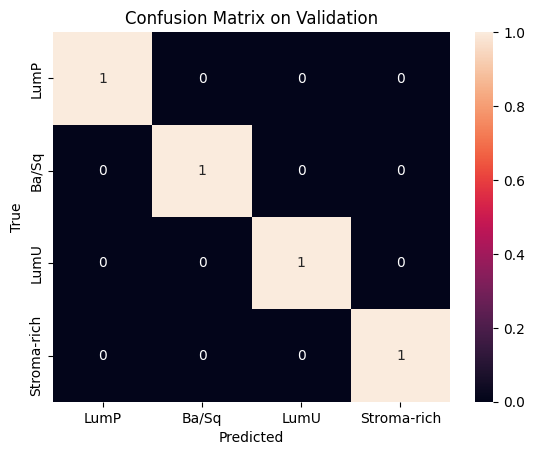

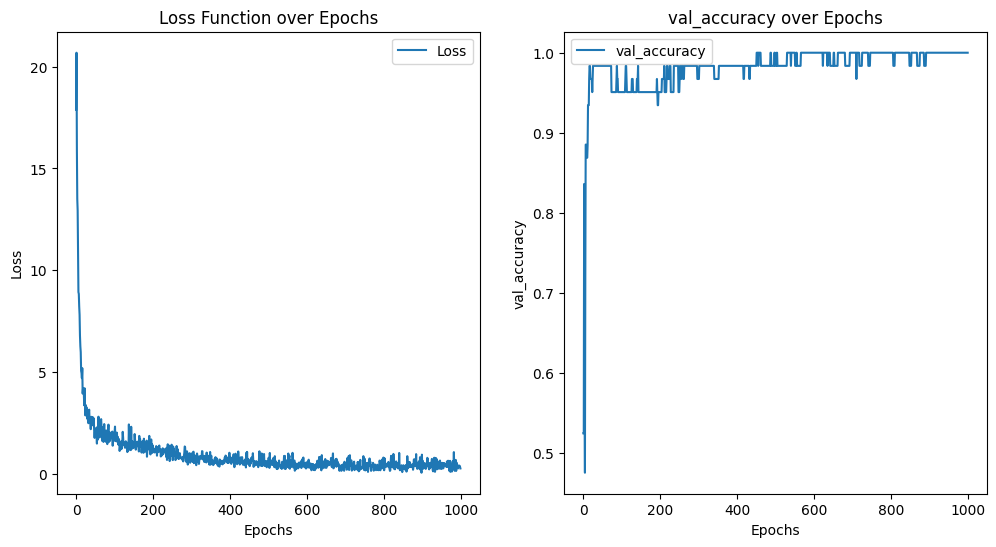

Fold: 2, Epoch: 001, Loss: 12.5664, Train_acc 0.4232, Val_acc 0.4098
Fold: 2, Epoch: 002, Loss: 14.4138, Train_acc 0.6639, Val_acc 0.7049
Fold: 2, Epoch: 003, Loss: 11.0214, Train_acc 0.6307, Val_acc 0.7049
Fold: 2, Epoch: 004, Loss: 9.4951, Train_acc 0.5560, Val_acc 0.6557
Fold: 2, Epoch: 005, Loss: 8.5110, Train_acc 0.8050, Val_acc 0.8689
Fold: 2, Epoch: 006, Loss: 7.7251, Train_acc 0.9212, Val_acc 0.9508
Fold: 2, Epoch: 007, Loss: 7.2066, Train_acc 0.9295, Val_acc 0.9508
Fold: 2, Epoch: 008, Loss: 7.1483, Train_acc 0.8838, Val_acc 0.8852
Fold: 2, Epoch: 009, Loss: 6.1935, Train_acc 0.8340, Val_acc 0.8525
Fold: 2, Epoch: 010, Loss: 5.8819, Train_acc 0.8091, Val_acc 0.8525
Fold: 2, Epoch: 011, Loss: 4.8029, Train_acc 0.8133, Val_acc 0.8525
Fold: 2, Epoch: 012, Loss: 5.1469, Train_acc 0.8755, Val_acc 0.9016
Fold: 2, Epoch: 013, Loss: 4.4339, Train_acc 0.9046, Val_acc 0.9016
Fold: 2, Epoch: 014, Loss: 4.3194, Train_acc 0.9253, Val_acc 0.9344
Fold: 2, Epoch: 015, Loss: 3.9634, Train_acc 

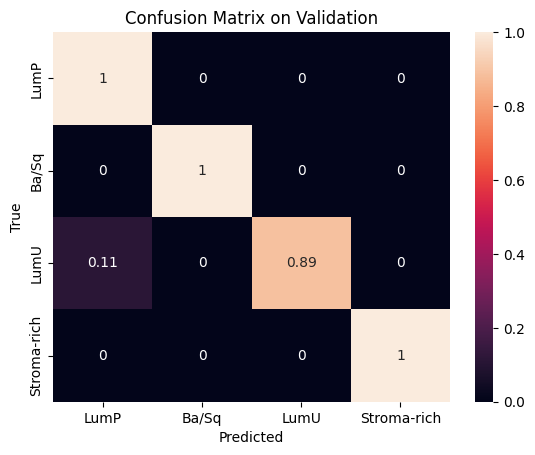

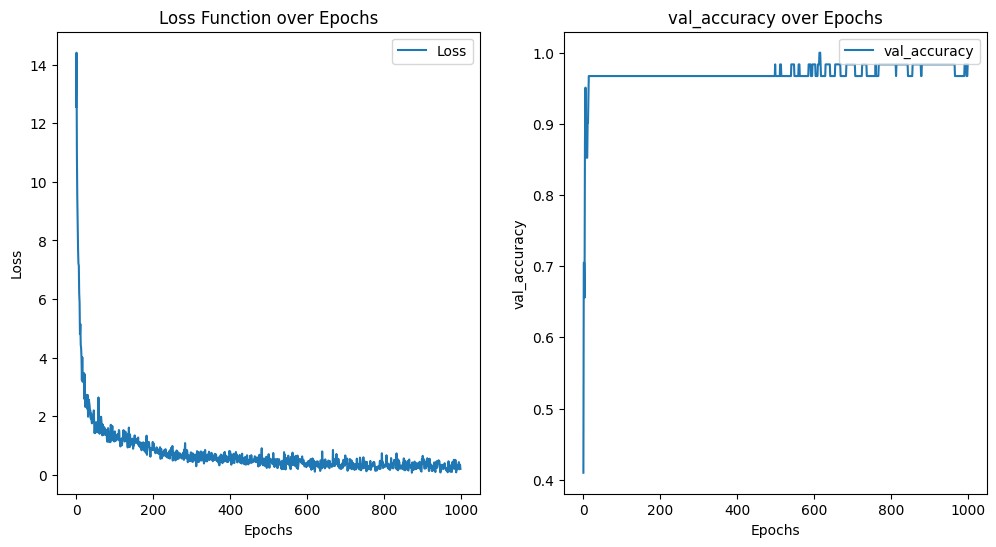

Fold: 3, Epoch: 001, Loss: 17.4459, Train_acc 0.5248, Val_acc 0.5167
Fold: 3, Epoch: 002, Loss: 19.0429, Train_acc 0.5041, Val_acc 0.5000
Fold: 3, Epoch: 003, Loss: 14.6199, Train_acc 0.8388, Val_acc 0.7833
Fold: 3, Epoch: 004, Loss: 12.7924, Train_acc 0.4876, Val_acc 0.4667
Fold: 3, Epoch: 005, Loss: 12.0227, Train_acc 0.6777, Val_acc 0.6333
Fold: 3, Epoch: 006, Loss: 9.9910, Train_acc 0.8719, Val_acc 0.8333
Fold: 3, Epoch: 007, Loss: 7.8384, Train_acc 0.8719, Val_acc 0.8500
Fold: 3, Epoch: 008, Loss: 7.9626, Train_acc 0.8512, Val_acc 0.8333
Fold: 3, Epoch: 009, Loss: 7.7772, Train_acc 0.8512, Val_acc 0.8333
Fold: 3, Epoch: 010, Loss: 8.0139, Train_acc 0.8678, Val_acc 0.8500
Fold: 3, Epoch: 011, Loss: 6.3656, Train_acc 0.8843, Val_acc 0.8667
Fold: 3, Epoch: 012, Loss: 5.5174, Train_acc 0.8967, Val_acc 0.8667
Fold: 3, Epoch: 013, Loss: 5.4126, Train_acc 0.9091, Val_acc 0.8500
Fold: 3, Epoch: 014, Loss: 5.0585, Train_acc 0.9050, Val_acc 0.8333
Fold: 3, Epoch: 015, Loss: 5.2628, Train_ac

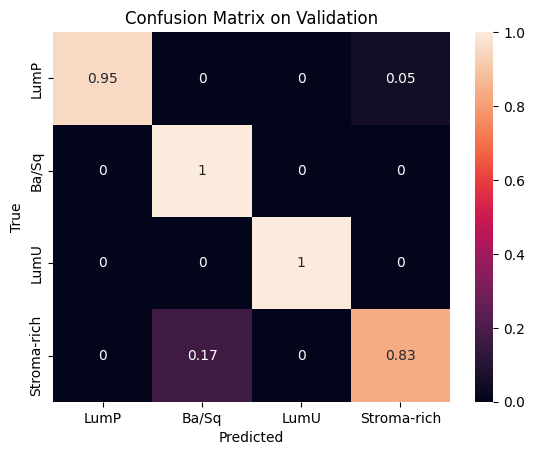

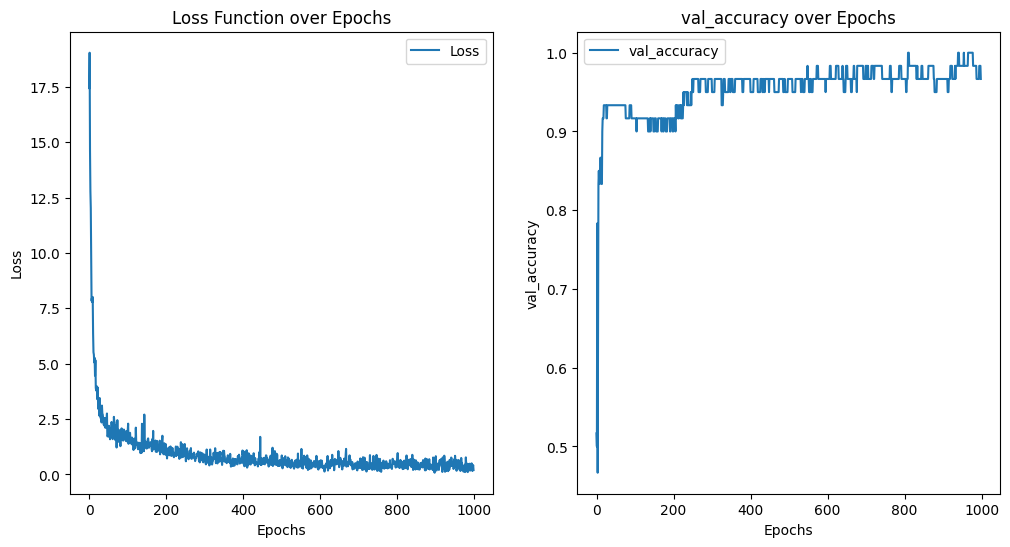

Fold: 4, Epoch: 001, Loss: 16.5367, Train_acc 0.4174, Val_acc 0.4333
Fold: 4, Epoch: 002, Loss: 17.1918, Train_acc 0.5372, Val_acc 0.5500
Fold: 4, Epoch: 003, Loss: 13.9427, Train_acc 0.6612, Val_acc 0.6000
Fold: 4, Epoch: 004, Loss: 12.2057, Train_acc 0.4545, Val_acc 0.4000
Fold: 4, Epoch: 005, Loss: 11.1032, Train_acc 0.7066, Val_acc 0.6833
Fold: 4, Epoch: 006, Loss: 10.1385, Train_acc 0.8719, Val_acc 0.8833
Fold: 4, Epoch: 007, Loss: 9.3255, Train_acc 0.9545, Val_acc 0.9333
Fold: 4, Epoch: 008, Loss: 10.4735, Train_acc 0.9587, Val_acc 0.9333
Fold: 4, Epoch: 009, Loss: 8.9166, Train_acc 0.9545, Val_acc 0.9333
Fold: 4, Epoch: 010, Loss: 8.2852, Train_acc 0.9298, Val_acc 0.8833
Fold: 4, Epoch: 011, Loss: 6.0908, Train_acc 0.8760, Val_acc 0.8667
Fold: 4, Epoch: 012, Loss: 5.5528, Train_acc 0.8471, Val_acc 0.8167
Fold: 4, Epoch: 013, Loss: 5.2794, Train_acc 0.8512, Val_acc 0.8167
Fold: 4, Epoch: 014, Loss: 5.6419, Train_acc 0.8678, Val_acc 0.8500
Fold: 4, Epoch: 015, Loss: 5.3749, Train_

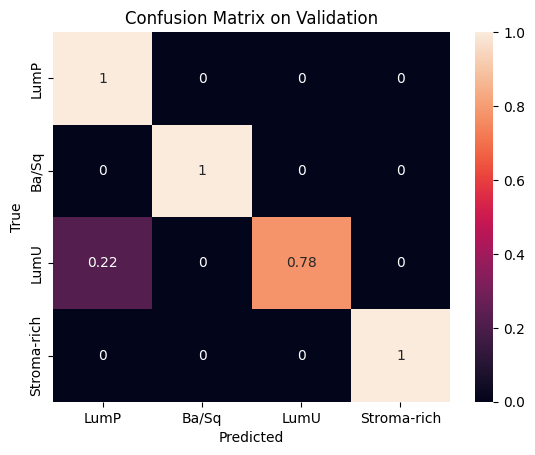

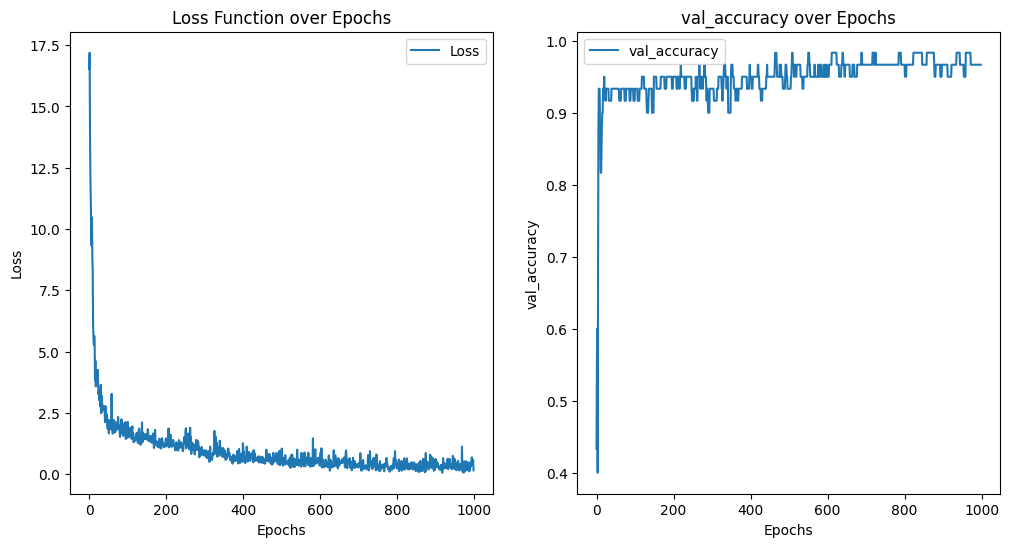

Fold: 5, Epoch: 001, Loss: 17.1857, Train_acc 0.5413, Val_acc 0.5167
Fold: 5, Epoch: 002, Loss: 18.3873, Train_acc 0.5455, Val_acc 0.5333
Fold: 5, Epoch: 003, Loss: 14.5604, Train_acc 0.5950, Val_acc 0.5667
Fold: 5, Epoch: 004, Loss: 12.1059, Train_acc 0.7810, Val_acc 0.8333
Fold: 5, Epoch: 005, Loss: 10.5783, Train_acc 0.5909, Val_acc 0.6333
Fold: 5, Epoch: 006, Loss: 10.4869, Train_acc 0.7686, Val_acc 0.8500
Fold: 5, Epoch: 007, Loss: 7.6718, Train_acc 0.8719, Val_acc 0.8333
Fold: 5, Epoch: 008, Loss: 7.8835, Train_acc 0.8719, Val_acc 0.8167
Fold: 5, Epoch: 009, Loss: 7.1836, Train_acc 0.8554, Val_acc 0.7833
Fold: 5, Epoch: 010, Loss: 7.6587, Train_acc 0.8554, Val_acc 0.7500
Fold: 5, Epoch: 011, Loss: 6.5785, Train_acc 0.8678, Val_acc 0.8000
Fold: 5, Epoch: 012, Loss: 5.8650, Train_acc 0.8719, Val_acc 0.8167
Fold: 5, Epoch: 013, Loss: 4.9760, Train_acc 0.9008, Val_acc 0.8833
Fold: 5, Epoch: 014, Loss: 4.3997, Train_acc 0.9132, Val_acc 0.9000
Fold: 5, Epoch: 015, Loss: 4.6094, Train_a

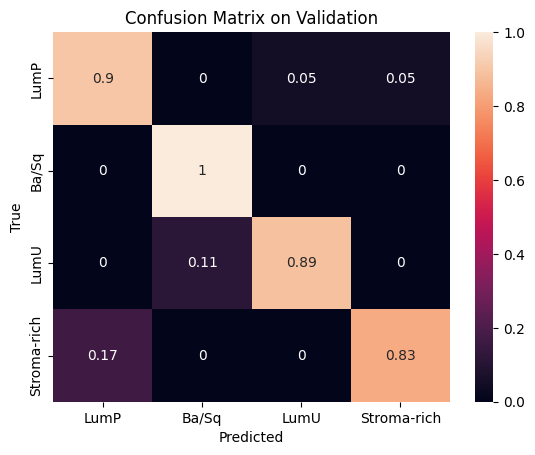

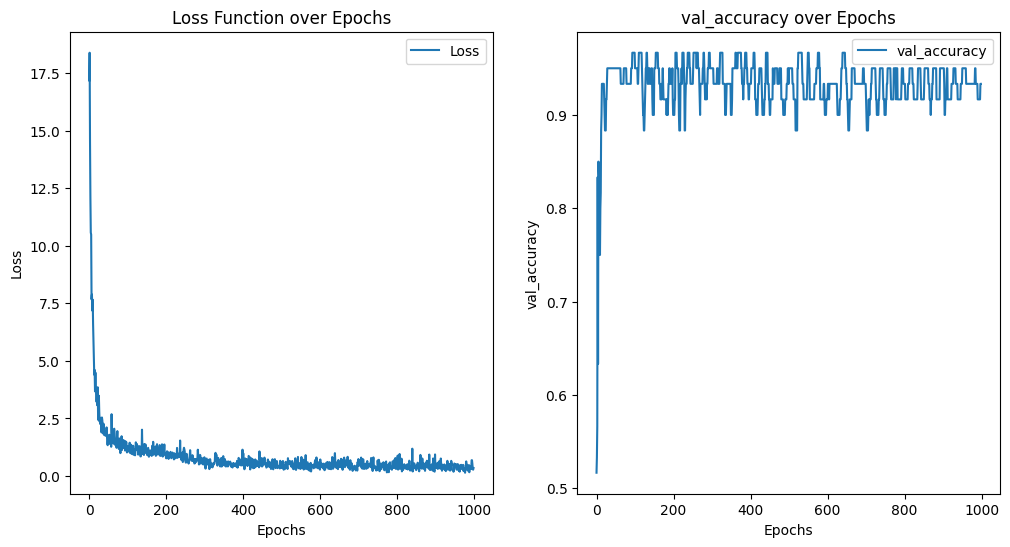

Mean Validation Accuracy: 0.9701, Std Validation Accuracy: 0.0221


In [ ]:
from sklearn.model_selection import train_test_split
similarity_threshold = 0.5

# Definition of the train/val indices and tests indices
train_val_indices, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=0.2, 
    random_state=1234
)

# Creating Data objects (= graphs)
train_val_data = get_data(train_val_indices, similarity_threshold, num_classes=4)
test_data = get_data(test_indices, similarity_threshold, num_classes=4)

# training the model
best_model, mean_val_acc = cross_validation_one_graph(train_val_data, k_folds=5, hidden_channels=20, heads=8, num_epochs=1000)

Test accuracy: 0.8947


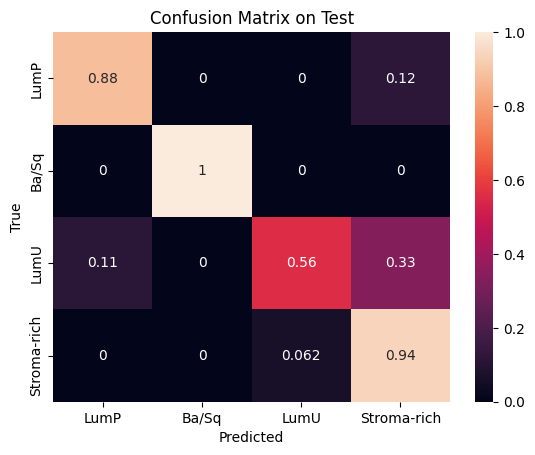

In [ ]:
# Testing the model

test_mask = torch.ones(test_data.num_nodes, dtype=torch.bool)
test_acc, y_pred = test(best_model, test_data, test_mask)
y_true = test_data.y[test_mask]

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

print(f'Test accuracy: {test_acc:.4f}')

labels = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich')
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_matrix_normalized, index=labels, columns=labels)  
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test')
plt.show()